### Environment Documentation: 
https://github.com/Kautenja/gym-super-mario-bros

### References:
1. Nicholas Renotte - Build an Mario AI Model with Python:
https://github.com/nicknochnack/MarioRL/blob/main/Mario%20Tutorial.ipynb <br> YouTube: https://www.youtube.com/watch?v=2eeYqJ0uBKE&ab_channel=NicholasRenotte <br>
2. Create custom environment wrapper: https://blog.paperspace.com/getting-started-with-openai-gym/ <br>
3. AI Learns To Play Super Mario Bros Using A Genetic Algorithm And Neural Network:
https://chrispresso.io/AI_Learns_To_Play_SMB_Using_GA_And_NN <br> GitHub https://github.com/Chrispresso/SuperMarioBros-AI
4. Super Mario Bros.:RAM map: https://datacrystal.romhacking.net/wiki/Super_Mario_Bros.:RAM_map <br>

# 1. Import Dependencies

In [ ]:
# from nes_py.wrappers import JoypadSpace
from gym_utils import CustomJoypadSpace
import gym 
import gym_super_mario_bros
from gym_super_mario_bros.actions import SIMPLE_MOVEMENT, RIGHT_ONLY 

from stable_baselines3 import PPO
from stable_baselines3.common.vec_env import DummyVecEnv, VecEnv, SubprocVecEnv
from stable_baselines3.common.evaluation import evaluate_policy
from stable_baselines3.common.monitor import Monitor
from stable_baselines3.common.callbacks import BaseCallback

import time
import matplotlib.pyplot as plt

from gym_utils import SMBRamWrapper

/Users/yumouwei/miniforge3/lib/python3.9/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [ ]:
env = gym_super_mario_bros.make('SuperMarioBros-1-1-v0')
# env = JoypadSpace(env, SIMPLE_MOVEMENT)
env = CustomJoypadSpace(env, SIMPLE_MOVEMENT)

# 2. Process Environment

In [3]:
# Setup cropping size
x0 = 0
x1 = 16
y0 = 0
y1 = 13
n_stack = 4
n_skip = 4

env_wrap = SMBRamWrapper(env, [x0, x1, y0, y1], n_stack=n_stack, n_skip=n_skip)

In [4]:
# test env_wrap
done = True
for i in range(150):
    if done:
        state = env_wrap.reset()
    state, reward, done, info = env_wrap.step(env_wrap.action_space.sample())

In [5]:
state.shape

(13, 16, 4)

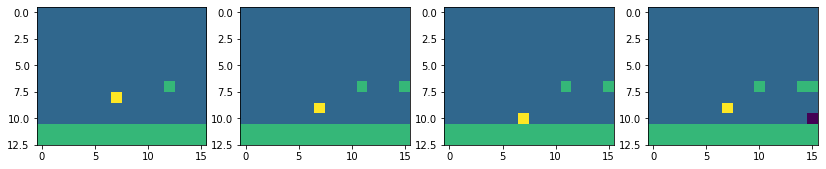

In [6]:
fig, ax = plt.subplots(1, n_stack, figsize=(14,10))
for i in range(n_stack):
    ax[i].imshow(state[:,:,n_stack-i-1], vmin=-1, vmax=2)
plt.show()

In [ ]:
# Apply other wrapper functions
env_wrap = Monitor(env_wrap)  # for tensorboard log
env_wrap = DummyVecEnv([lambda: env_wrap])

# 3. Setup RL Model

In [ ]:
# Callbacks

# Save intermediate models
# Copied from Nicholas Renotte's code
class TrainAndLoggingCallback(BaseCallback):

    def __init__(self, check_freq, save_path, 
                 starting_steps=0, verbose=1):
        super(TrainAndLoggingCallback, self).__init__(verbose)
        self.check_freq = check_freq
        self.save_path = save_path
        self.starting_steps = starting_steps

    def _init_callback(self):
        if self.save_path is not None:
            os.makedirs(self.save_path, exist_ok=True)

    def _on_step(self):
        if self.n_calls % self.check_freq == 0:
            model_path = os.path.join(self.save_path, 'best_model_{}'.format(self.n_calls + int(self.starting_steps)))
            self.model.save(model_path)

        return True
    
# Linear learning rate schedule
# https://stable-baselines3.readthedocs.io/en/master/guide/examples.html#learning-rate-schedule
from typing import Callable

def linear_schedule(initial_value: float) -> Callable[[float], float]:
    """
    Linear learning rate schedule.

    :param initial_value: Initial learning rate.
    :return: schedule that computes
      current learning rate depending on remaining progress
    """
    def func(progress_remaining: float) -> float:
        """
        Progress will decrease from 1 (beginning) to 0.

        :param progress_remaining:
        :return: current learning rate
        """
        return progress_remaining * initial_value

    return func

In [ ]:
### MODIFY THESE TWO DIRECTORIES BEFORE TRAINING A NEW MODEL ###
MODEL_DIR = './models/NEW_MODEL_DIR'
LOG_DIR = './logs/NEW_LOG_DIR'

In [ ]:
model = PPO('MlpPolicy', env_wrap, verbose=1, learning_rate=linear_schedule(3e-4), tensorboard_log=LOG_DIR) 

In [ ]:
callback = TrainAndLoggingCallback(check_freq=1e5, starting_steps=0, save_path=MODEL_DIR)

# Train the model

In [ ]:
t_start = time.time()

model.learn(total_timesteps=10e6, callback=callback)

t_elapsed = time.time() - t_start

In [ ]:
print('Wall time: {} s'.format(round(t_elapsed, 2)))

# Save and load trained model

In [ ]:
# Save model
model_path = os.path.join(MODEL_DIR, 'SAVED_MODEL_NAME')
model.save(model_path)

In [ ]:
del model

In [ ]:
# Load model
MODEL_DIR = './models/SAVED_MODEL_NAME'
LOG_DIR = './logs/SAVED_LOG_DIR'

model_path = os.path.join(MODEL_DIR, 'SAVED_MODEL_NAME')
model = PPO.load(model_path, env=env_wrap)

# Open tensorboard

In [ ]:
LOG_NAME = 'PPO_5'
TB_LOG = os.path.join(LOG_DIR, LOG_NAME)

!tensorboard --logdir={TB_LOG}

# 4. Test the Trained Model

In [ ]:
from stable_baselines3.common.evaluation import evaluate_policy

In [ ]:
evaluate_policy(model, env_wrap, n_eval_episodes=1, deterministic=True, render=False, return_episode_rewards=False)

In [ ]:
episode = 1

for episode in range(1, episode+1):
    states = env_wrap.reset()
    done = False
    score = 0
    
    while not done:
        env_wrap.render()
        action, _ = model.predict(states, deterministic=True)
        states, reward, done, info = env_wrap.step(action)
        score += reward
        time.sleep(0.01)
    print('Episode:{} Score:{}'.format(episode, score))
#env.close()